In [40]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import pickle
from plot_tool import *
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [41]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
device = torch.device("cuda:0") #Подрубайтунг

In [174]:
train_folder = "stats/"
points= 20

In [175]:
def saveStats(data, name):
    with open('stats/'+str(name)+".stat", 'wb') as f:
        pickle.dump(data, f)
        
def readStats(name):
    with open('stats/'+str(name), 'rb') as f:
        return pickle.load(f)

In [180]:
scaler = MinMaxScaler(feature_range=(-1, 1))

class CryptoDataset(Dataset):
    def __init__(self, folder, transform=None, cutoff = 25):
        self.transform = transform
        self.folder = folder
        
        files = os.listdir(self.folder)
        
        self.count = len(files)
        self.games_path = list()
        self.cutoff = cutoff
        
        for f in os.listdir(self.folder):
            self.games_path.append(f)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        path = self.games_path[index]
        
        base_stats = readStats(path)

        close_train = np.array(base_stats.closes.getData()[:self.cutoff])
        close_gt = np.array(base_stats.closes.getData()[self.cutoff:])
        
        trainOut = np.array([close_train, close_train])
        gtOut = np.array([close_gt, close_gt])
        
        trainOut = torch.from_numpy(trainOut).type(torch.Tensor)
        gtOut = torch.from_numpy(gtOut).type(torch.Tensor)
           
        return trainOut, gtOut, index

In [181]:
train_dataset = CryptoDataset(train_folder, transform=transforms.Compose([transforms.ToTensor(),]))

In [182]:
len(train_dataset)

10

torch.Size([2, 25]) torch.Size([2, 5])


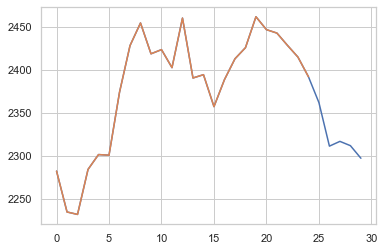

In [192]:
sns.set_style("whitegrid")
a, b, c = train_dataset[0]
print(a.shape, b.shape)
res = np.concatenate([a[0], b[0]])
plt.plot(res)
plt.plot(a[0])

In [193]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [194]:
batch_size = 1

data_size = len(train_dataset)
print(data_size)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

10


In [195]:
#for i_step, (x, y, z) in enumerate(train_loader):
#    print(i_step, x, y, z)

In [196]:
import copy

def compute_accuracy(model, loader, device):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()  # Evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for i_step, (x, y, _) in enumerate(loader):
            x, y = x.float(), y.float()
            prediction = model(x.to(device)).cpu()
            #print(prediction.shape)
            
            
    
    return 1.0

def train_model_v2(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
            x=x.float()
            y=y.float()
            print(x.shape)
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    y_data = y[i][j]
                    pred_data = np.around(prediction.cpu().detach().numpy()[i][j])
                    countMap = map(lambda x, y: 1 if x==y else 0, y_data.reshape(-1), pred_data.reshape(-1))
                    #print(pred_data)

                    correct_samples += sum(list(countMap))/(y_data.shape[0]*y_data.shape[1])
                    total_samples += 1
            
            loss_accum += loss_value
            
        ave_loss = loss_accum / i_step
        
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, device)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
            
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [197]:
model = GRU(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
print(model)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [198]:
loss_history, train_history, val_history = train_model_v2(model, train_loader, val_loader, criterion, optimiser, 50)


torch.Size([1, 2, 25])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 25